In [1]:
!pip install matplotlib numpy opencv-python tensorflow scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from scipy.stats import pearsonr

In [3]:
# Define dataset paths
dataset_path = r"C:\Users\ASUS\Desktop\University\sem-4\FER2013_Sample_100"
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")

# Define noisy dataset paths
noisy_dataset_path = r"C:\Users\ASUS\Desktop\University\sem-4\FER2013_Sample_100_Noisy_Images"
noisy_train_path = os.path.join(noisy_dataset_path, "train")
noisy_test_path = os.path.join(noisy_dataset_path, "test")

# Ensure noisy dataset directories exist
for path in [noisy_train_path, noisy_test_path]:
    if not os.path.exists(path):
        os.makedirs(path)

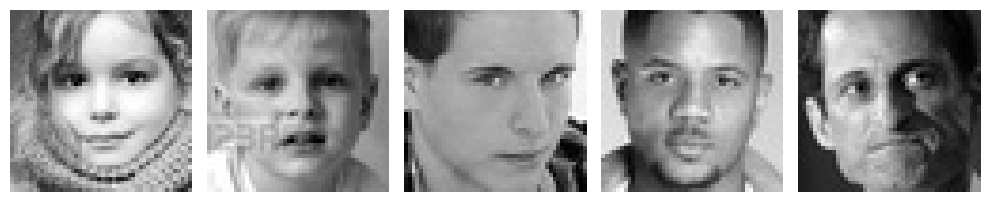

In [4]:
def display_sample_images(folder_path, num_images=5):
    categories = os.listdir(folder_path)
    fig, axes = plt.subplots(len(categories), num_images, figsize=(10, 10))

    # for i, category in enumerate(categories):
    #     category_path = os.path.join(folder_path, category)
    #     image_files = os.listdir(category_path)[:num_images]

    #     for j, image_file in enumerate(image_files):
    #         img_path = os.path.join(category_path, image_file)
    #         img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
    #         img = cv2.resize(img, (48, 48)) 

    #         axes[i, j].imshow(img, cmap='gray')
    #         axes[i, j].axis("off")

    #     axes[i, 0].set_ylabel(category, fontsize=12)

    category_path = os.path.join(folder_path, "neutral")
    image_files = os.listdir(category_path)[:num_images]

    for j, image_file in enumerate(image_files):
        img_path = os.path.join(category_path, image_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
        img = cv2.resize(img, (48, 48)) 
        
        axes[j].imshow(img, cmap='gray')
        axes[j].axis("off")

    axes[0].set_ylabel("neutral", fontsize=12)

    plt.tight_layout()
    plt.show()

display_sample_images(train_path, num_images=5)


In [5]:
# Function to add Gaussian noise
def add_gaussian_noise(image, mean=0, std=0.05):  
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = 255*(image + noise)
    # noisy_image = cv2.add(image, noise)  # Add noise to the image
    return noisy_image

# Function to process images and save noisy versions
def process_images(input_folder, output_folder, category="neutral"):
    category_path = os.path.join(input_folder, category)
    noisy_category_path = os.path.join(output_folder, category)

    # Ensure category subfolder exists in noisy images
    if not os.path.exists(noisy_category_path):
        os.makedirs(noisy_category_path)

    # Process images inside category folder
    for img_name in tqdm(os.listdir(category_path), desc=f"Processing {category} in {output_folder}"):
        img_path = os.path.join(category_path, img_name)
        noisy_img_path = os.path.join(noisy_category_path, img_name)

        # Read and process image
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue  # Skip unreadable images
            
        noisy_image = add_gaussian_noise(image/255.0)

        # Save noisy image
        cv2.imwrite(noisy_img_path, noisy_image)

# Apply noise to both train and test datasets for neutral category
process_images(train_path, noisy_train_path, category="neutral")
process_images(test_path, noisy_test_path, category="neutral")

print("✅ Noisy images successfully generated and saved in 'FER2013_Noisy_Images' folder.")

Processing neutral in C:\Users\ASUS\Desktop\University\sem-4\FER2013_Sample_100_Noisy_Images\train: 100%|█| 100/100 [00
Processing neutral in C:\Users\ASUS\Desktop\University\sem-4\FER2013_Sample_100_Noisy_Images\test: 100%|█| 25/25 [00:00

✅ Noisy images successfully generated and saved in 'FER2013_Noisy_Images' folder.


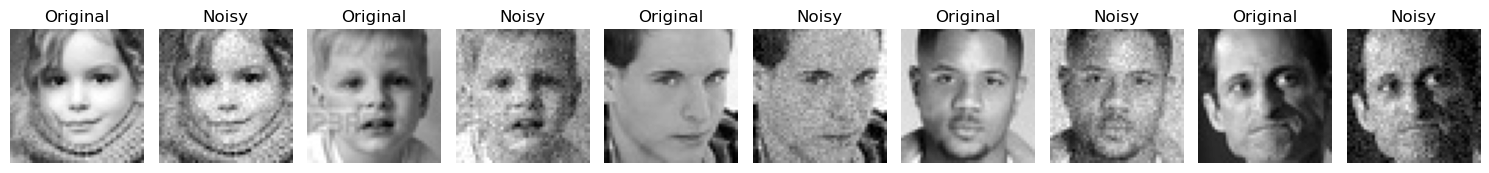

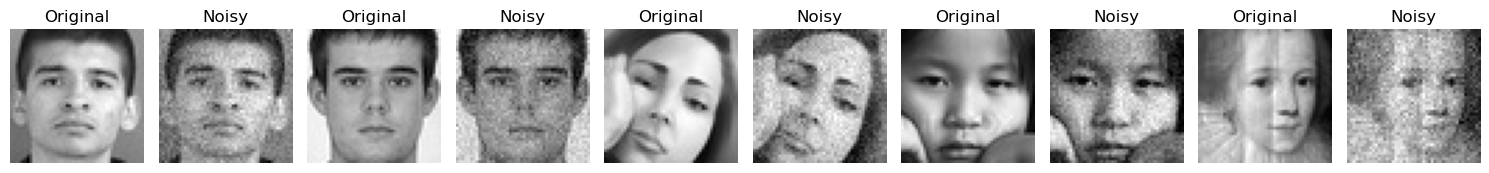

In [6]:
def display_original_and_noisy_images(original_folder, noisy_folder, num_images=5, category="neutral"):
    original_category_path = os.path.join(original_folder, category)
    noisy_category_path = os.path.join(noisy_folder, category)

    if not os.path.exists(noisy_category_path):
        print(f"Skipping {category}, noisy folder not found.")
        return

    fig, axes = plt.subplots(1, num_images * 2, figsize=(15, 5))

    image_files = os.listdir(original_category_path)[:num_images]

    for j, image_file in enumerate(image_files):
        original_img_path = os.path.join(original_category_path, image_file)
        noisy_img_path = os.path.join(noisy_category_path, image_file)

        original_img = cv2.imread(original_img_path, cv2.IMREAD_GRAYSCALE)
        noisy_img = cv2.imread(noisy_img_path, cv2.IMREAD_GRAYSCALE)

        if original_img is None or noisy_img is None:
            continue  # Skip if images are unreadable

        original_img = cv2.resize(original_img, (48, 48))
        noisy_img = cv2.resize(noisy_img, (48, 48))

        # Show original image
        axes[j * 2].imshow(original_img, cmap='gray')
        axes[j * 2].axis("off")
        axes[j * 2].set_title("Original")

        # Show noisy image
        axes[j * 2 + 1].imshow(noisy_img, cmap='gray')
        axes[j * 2 + 1].axis("off")
        axes[j * 2 + 1].set_title("Noisy")

    plt.tight_layout()
    plt.show()

# Display original and noisy images for neutral category
display_original_and_noisy_images(train_path, noisy_train_path, num_images=5, category="neutral")
display_original_and_noisy_images(test_path, noisy_test_path, num_images=5, category="neutral")

In [7]:
def load_images(folder_path, category="neutral", image_size=(48, 48)):
    data = []
    category_path = os.path.join(folder_path, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, image_size)
        data.append(img)
    return np.array(data).astype("float32") / 255.0  # Normalize images

# Load noisy and clean images for the "neutral" category
X_noisy = load_images(noisy_train_path, category="neutral")
X_clean = load_images(train_path, category="neutral")

print("Images Loaded successfully!")

Images Loaded successfully!


In [8]:
def build_dae():
    input_img = tf.keras.Input(shape=(48, 48, 1))

    # Encoder 
    x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    # x = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    # x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    # x = tf.keras.layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    # x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)

    # Decoder 
    # x = tf.keras.layers.Conv2DTranspose(256, (3, 3), activation="relu", padding="same")(x)
    # x = tf.keras.layers.UpSampling2D((2, 2))(x)
    # x = tf.keras.layers.Conv2DTranspose(128, (3, 3), activation="relu", padding="same")(x)
    # x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    output_img = tf.keras.layers.Conv2D(1, (3, 3), activation="linear", padding="same")(x)

    model = tf.keras.Model(input_img, output_img)
    model.compile(optimizer="adam", loss="mse")
    
    return model

# Build the DAE model
dae = build_dae()
dae.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,145 (149.00 KB)

 Trainable params: 38,145 (149.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold

# K-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
best_val_loss = float("inf")

# Build the model once
dae = build_dae()
initial_weights = dae.get_weights()  # Store initial weights

for train_idx, val_idx in kf.split(X_noisy):
    X_train_fold, X_val_fold = X_noisy[train_idx], X_noisy[val_idx]
    y_train_fold, y_val_fold = X_clean[train_idx], X_clean[val_idx]

    dae.set_weights(initial_weights)  # Reset weights instead of re-building

    checkpoint = ModelCheckpoint("temp_best_model.keras", monitor="val_loss", save_best_only=True, verbose=0)
    history = dae.fit(X_train_fold, y_train_fold, epochs=500, batch_size=16,
                      validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint], verbose=0)

    dae.load_weights("temp_best_model.keras")  # Load best weights for this fold
    val_loss = min(history.history["val_loss"])

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        dae.save("best_dae_model.keras")  # Save the best model

print("Best model saved as 'best_dae_model.keras'")

Best model saved as 'best_dae_model.keras'


In [10]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Performance Metrics Calculation (MSE, PSNR, SSIM)
def calculate_metrics(original, denoised):
    metrics = {"MSE": [], "PSNR": [], "SSIM": []}

    for i in range(original.shape[0]):
        orig, denoised_img = original[i].squeeze(), denoised[i].squeeze()

        # Mean Squared Error
        mse_value = np.mean((orig - denoised_img) ** 2)
        metrics["MSE"].append(mse_value)

        # Peak Signal-to-Noise Ratio
        psnr_value = psnr(orig, denoised_img, data_range=orig.max() - orig.min())
        metrics["PSNR"].append(psnr_value)

        # Structural Similarity Index
        ssim_value = ssim(orig, denoised_img, data_range=orig.max() - orig.min())
        metrics["SSIM"].append(ssim_value)

    # Compute mean values for each metric
    return {key: np.mean(values) for key, values in metrics.items()}


In [14]:
# Load the best model
best_model = tf.keras.models.load_model("best_dae_model.keras")

# Load 20% unseen test data
X_unseen = load_images(noisy_test_path, category = "neutral")
y_unseen = load_images(test_path, category = "neutral")

# Predict denoised images using the trained model
denoised_images = best_model.predict(X_unseen)

# Calculate metrics (MSE, PSNR, SSIM)
denoised_metrics = calculate_metrics(y_unseen, denoised_images)

# Print results
print("Comparison of Original Image and Denoised Image:")
for metric, value in denoised_metrics.items():
    print(f"{metric}: {value:.4f}")

noisy_metrics = calculate_metrics(y_unseen, X_unseen)
# Print results
print("Comparison of Original Image and Noisy Image:")
for metric, value in noisy_metrics.items():
    print(f"{metric}: {value:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
Comparison of Original Image and Denoised Image:
MSE: 0.0011
PSNR: 28.0165
SSIM: 0.9163
Comparison of Original Image and Noisy Image:
MSE: 0.0026
PSNR: 24.2908
SSIM: 0.8093


In [12]:
import os

# Directory to save denoised images
denoised_images_dir = r"C:\Users\ASUS\Desktop\University\sem-4\FER2013_Denoised_Images"
neutral_denoised_images = os.path.join(denoised_images_dir, "neutral")

if not os.path.exists(neutral_denoised_images):
    os.makedirs(neutral_denoised_images)

# Save denoised images
for i in range(len(denoised_images)):
    denoised_img = denoised_images[i].squeeze()
    denoised_img_path = os.path.join(neutral_denoised_images, f"denoised_{i+1}.png")
    plt.imsave(denoised_img_path, denoised_img, cmap='gray')

print(f"Denoised images saved to {denoised_images_dir} directory.")

Denoised images saved to C:\Users\ASUS\Desktop\University\sem-4\FER2013_Denoised_Images directory.


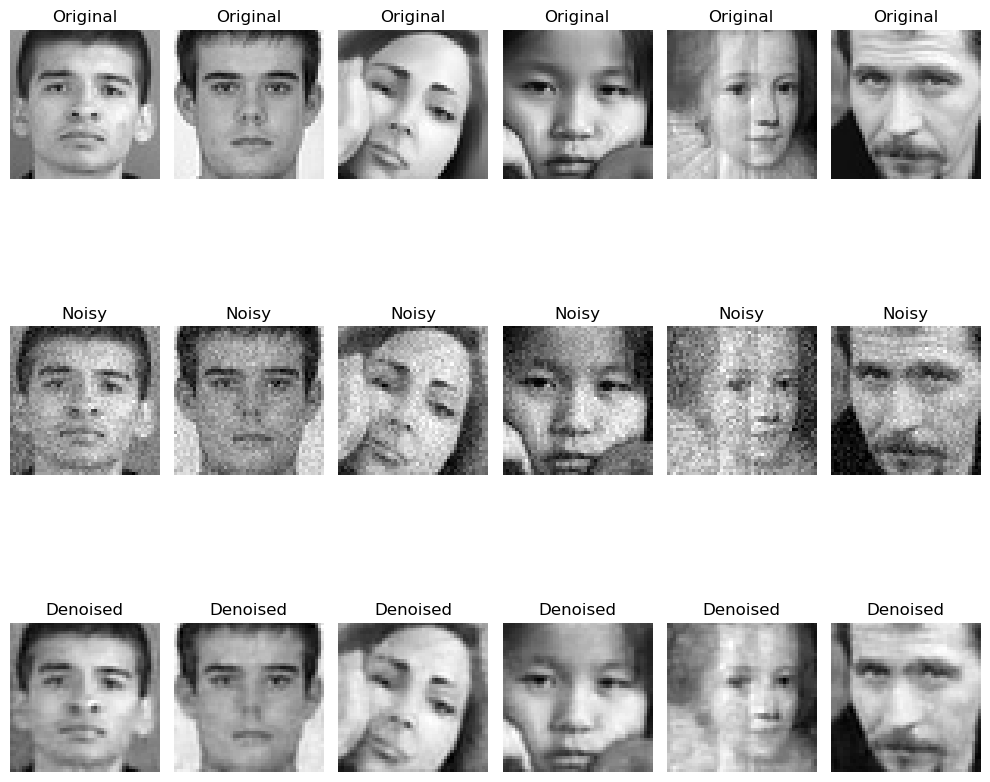

In [13]:
import matplotlib.pyplot as plt

# Number of images to display
num_images_to_display = 6

plt.figure(figsize=(10, 10))
for i in range(num_images_to_display):
    # Original clean image
    plt.subplot(3, num_images_to_display, i + 1)
    plt.imshow(y_unseen[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title("Original")

    # Noisy image
    plt.subplot(3, num_images_to_display, i + num_images_to_display + 1)
    plt.imshow(X_unseen[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title("Noisy")

    # Denoised image
    plt.subplot(3, num_images_to_display, i + 2 * num_images_to_display + 1)
    plt.imshow(denoised_images[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title("Denoised")

plt.tight_layout()
plt.show()
